In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# load the file
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
gender = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

In [3]:
# make a copy
traincp = train.copy()
testcp = test.copy()

In [4]:
# fill in missing Age with mean
traincp=traincp.fillna(value=traincp["Age"].mean())
testcp=testcp.fillna(value=testcp["Age"].mean())

In [5]:
# drop cabin
traincp=traincp.drop(columns=["Cabin"])
testcp=testcp.drop(columns=["Cabin"])

In [6]:
# replace missing value for "Embarked" in train data with mode
traincp['Embarked'] = traincp['Embarked'].fillna(traincp['Embarked'].mode())
testcp['Embarked'] = testcp['Embarked'].fillna(testcp['Embarked'].mode())
print(testcp[testcp['Embarked'].isnull()])
print(traincp[traincp['Embarked'].isnull()])
#check the example

Empty DataFrame
Columns: [PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Embarked]
Index: []
Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Embarked]
Index: []


In [7]:
#mapping catagorical features to numerical value
traincp['Survived'].value_counts(normalize=True)
traincp =pd.get_dummies(traincp, columns=['Sex', 'Embarked'],drop_first = True)
testcp =pd.get_dummies(testcp, columns=['Sex', 'Embarked'],drop_first = True)


In [8]:
# import library 
from sklearn import preprocessing

In [9]:
# Apply min-max normalization on a single attribute
minmax_scaler = preprocessing.MinMaxScaler().fit(train[['Fare']])
traincp['Fare_minmax']=minmax_scaler.transform(train[['Fare']])
minmax_scaler = preprocessing.MinMaxScaler().fit(test[['Fare']])
testcp['Fare_minmax']=minmax_scaler.transform(test[['Fare']])
# Apply z-score normalization on a single attribute
zscore_scaler = preprocessing.StandardScaler().fit(train[['Fare']])
traincp['Fare_zscore']=zscore_scaler.transform(train[['Fare']])
zscore_scaler = preprocessing.StandardScaler().fit(test[['Fare']])
testcp['Fare_zscore']=zscore_scaler.transform(test[['Fare']])

In [10]:
# define features
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q','Embarked_S']

# define target varialbe
target = ['Survived']

# Get the data
X = traincp [features]
y = traincp [target]

# import train_test split
from sklearn.model_selection import train_test_split
# split train data into train and test, 60% in training and 40% in testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 42)

In [11]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
# import evaluation tools
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [12]:
# define our model decision tree model with some hyperparameters
model = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 41)
# build the decision tree model based on defalut hyperparameter settings
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=41)

In [13]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 7

# Function to plot the results
def plot_fitting_curves(results):
    results.plot("min_leaves")
    plt.ylabel("Accuracy")
    plt.xlabel("Min samples per leaf (inverse of complexity)")
    plt.show()

Size of training data: 427
Size of validation data: 107
Size of test data:357


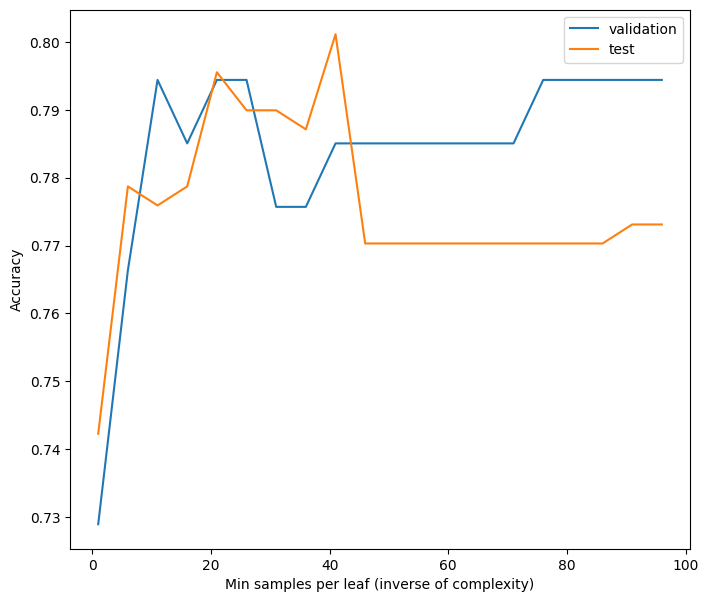

In [14]:
# Split into a sub training set and validation set
X_strain, X_val, y_strain, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"Size of training data: {X_strain.shape[0]}")
print(f"Size of validation data: {X_val.shape[0]}")
print(f"Size of test data:{X_test.shape[0]}")
min_leaves = range(1,100,5)

Accuracy_val = []
Accuracy_test = []
for m in min_leaves:
    # We train the model with only a portion of the training data (the 'sub-training' data set)
    model_val = DecisionTreeClassifier(min_samples_leaf=m, random_state=42)
    model_val.fit(X_strain, y_strain)
    predictions_val = model_val.predict(X_val)
    model_test = DecisionTreeClassifier(min_samples_leaf=m, random_state=42)
    model_test.fit(X_train,y_train)
    predictions_test = model_test.predict(X_test)
    # And we evaluate in the validation set
    accuracy_val = accuracy_score(y_val, predictions_val,normalize=True, sample_weight=None)
    Accuracy_val.append(accuracy_val)
    accuracy_test = accuracy_score(y_test, predictions_test,normalize=True, sample_weight=None)
    Accuracy_test.append(accuracy_test)
    

results = pd.DataFrame({"min_leaves": min_leaves, "validation":Accuracy_val, "test":Accuracy_test})
plot_fitting_curves(results)

In [15]:
# import cross validation 
from sklearn.model_selection import cross_val_score

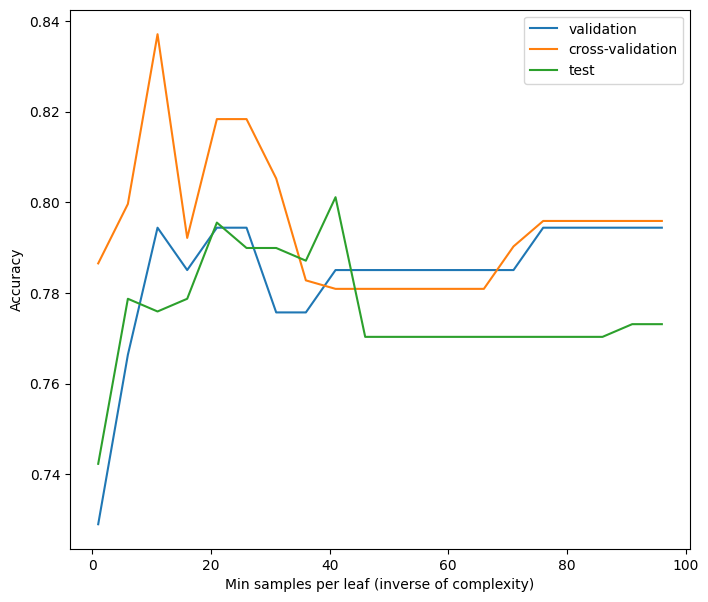

In [16]:
from sklearn.model_selection import cross_val_predict
Accuracy_cv = []
for m in min_leaves:
    # Define hyperparamter for complexity control
    algorithm = DecisionTreeClassifier(min_samples_leaf=m, random_state=42)
    # Evaluate the performance of the hyperparameter with cross validation. 
    # The parameter 'cv' is used to determine the number of splits (folds). 
    predictions_cv = cross_val_predict(algorithm, X_train, y_train, cv=5)
    accuracy_cv = accuracy_score(y_train, predictions_cv,normalize=True, sample_weight=None)
    Accuracy_cv.append(accuracy_cv)

results = pd.DataFrame({"min_leaves": min_leaves, "validation":Accuracy_val, "cross-validation":Accuracy_cv, "test":Accuracy_test})
plot_fitting_curves(results)
# The model converge

Text(0, 0.5, 'Accuracy')

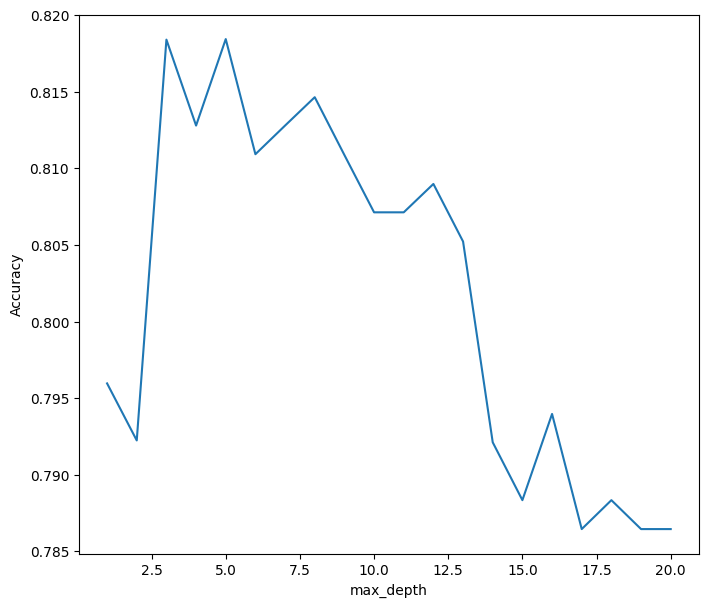

In [17]:
#finding optimal max_depth
# List of values to try for max_depth:
max_depth_range = list(range(1, 21))  # Adjust this range according to your needs

# List to store the average RMSE for each value of max_depth:
accuracy_scores = []

# Use 5-fold cross-validation with each value of max_depth:
for depth in max_depth_range:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    accuracy_score = cross_val_score(tree, X_train, y_train, cv=5, scoring='accuracy')
    accuracy_scores.append(np.mean(accuracy_score))

# Plot max_depth (x-axis) versus RMSE (y-axis):
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
#optimal at 3,5

In [18]:
#change the hyperparameter to the optimal value.
model = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 75)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=75)

In [19]:
# make prediction on split_test data
pre_val = model.predict(X_train)

In [20]:
from sklearn.metrics import accuracy_score

# evaluate result 
print("Accuracy:",accuracy_score(y_train, pre_val, normalize=True, sample_weight=None))
print("Confusion Matrix:", '\n', confusion_matrix(y_train, pre_val))

Accuracy: 0.797752808988764
Confusion Matrix: 
 [[330   3]
 [105  96]]


In [21]:
from sklearn.model_selection import GridSearchCV
# make an array of depths to choose from 1 to 20
depths = np.arange(1, 21)
# define the number to try out for max leaf nodes
num_leafs = [5, 10, 20, 50, 75,100]
try_grid = [{'max_depth':depths,
              'max_leaf_nodes':num_leafs}]

In [22]:
DTM = GridSearchCV(DecisionTreeClassifier(), param_grid=try_grid, cv=10)

In [23]:
DTM.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                          'max_leaf_nodes': [5, 10, 20, 50, 75, 100]}])

In [24]:
print(DTM.best_params_,DTM.best_score_)

{'max_depth': 6, 'max_leaf_nodes': 10} 0.8312718378756113


In [25]:
model = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 10)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)

In [26]:
pre_val = model.predict(X_train)
from sklearn.metrics import accuracy_score

# evaluate result 
print("Accuracy:",accuracy_score(y_train, pre_val, normalize=True, sample_weight=None))
print("Confusion Matrix:", '\n', confusion_matrix(y_train, pre_val))

Accuracy: 0.8576779026217228
Confusion Matrix: 
 [[314  19]
 [ 57 144]]


In [27]:
# make prediction on real test data
pre_val = model.predict(testcp[features])

In [28]:
#make a submission dataFrame
submission = pd.DataFrame({
    "PassengerId": testcp["PassengerId"],
    "Survived": pre_val
})

# Save the submission dataframe as a csv file
submission.to_csv('submission.csv', index=False)
